# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler

random_state = RandomState(12345)


BUDGET = 10_000_000_000         # бюджет на разработку региона (в рублях)
INCOME_PER_UNIT = 450_000       # доход за 1 тыс. баррелей (в рублях)
N_WELLS = 200                   # количество разрабатываемых скважин
N_TOTAL = 500                   # количество исследуемых точек
RANDOM_SEED = 42                # для воспроизводимости train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка и подготовка данных

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

regions = [data_0, data_1, data_2]


In [3]:
for i, data in enumerate(regions):
    print(f"Регион {i}:")
    print(data.info())
    print("Пропуски:", data.isna().sum().sum())
    print("Дубликаты:", data.drop('id', axis=1).duplicated().sum(), "\n")
    print("Дубликаты id", data['id'].duplicated().sum())

Регион 0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Пропуски: 0
Дубликаты: 0 

Дубликаты id 10
Регион 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Пропуски: 0
Дубликаты: 0 

Дубликаты id 4
Регион 2:
<class 

In [4]:
for i, data in enumerate(regions):
    id_counts = {}
    new_ids = []

    for orig_id in data['id']:
        if orig_id not in id_counts:
            id_counts[orig_id] = 0
            new_ids.append(orig_id)
        else:
            id_counts[orig_id] += 1
            new_ids.append(f"{orig_id}_{id_counts[orig_id]}")
    
    data['id'] = new_ids
    regions[i] = data
for i, data in enumerate(regions):
    print(f"Регион {i}:")
    print("Дубликаты id", data['id'].duplicated().sum())

Регион 0:
Дубликаты id 0
Регион 1:
Дубликаты id 0
Регион 2:
Дубликаты id 0


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

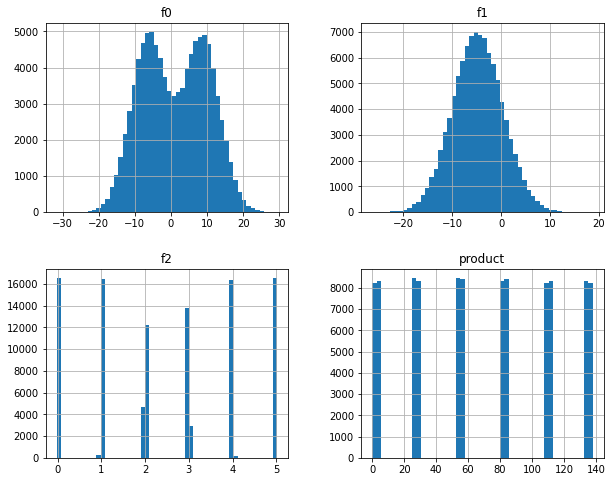

In [5]:
data_1[['f0', 'f1', 'f2', 'product']].hist(bins=50, figsize=(10, 8))


Распределение объёма скважин во втором регионе выглядит аномальным

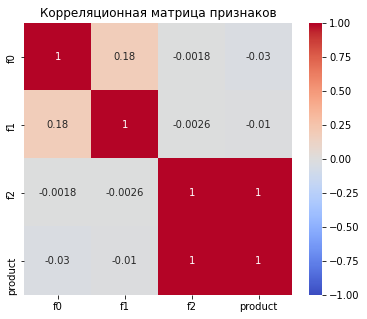

In [6]:
features = data_1[['f0', 'f1', 'f2', 'product']]

corr_matrix = features.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица признаков')
plt.show()

Ёмкость скважины однозначно определяется признаком f2. Удалим его из данных.

In [7]:
data_1 = data_1.drop('f2', axis=1)

## Обучение и проверка модели

In [8]:


def train_and_validate(data):
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']

    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_SEED
    )
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)

    rmse = mean_squared_error(y_valid, predictions, squared=False)
    mean_pred = predictions.mean()

    return model, X_valid, y_valid.reset_index(drop=True), pd.Series(predictions), rmse, mean_pred


## Подготовка к расчёту прибыли

In [9]:
ONE_WELL_COST = BUDGET / N_WELLS
BREAKEVEN_VOLUME = ONE_WELL_COST / INCOME_PER_UNIT

print(f"Достаточный объём для безубыточности: {BREAKEVEN_VOLUME:.2f} тыс. баррелей\n")

def calculate_profit(predictions, target):
    top_200_ids = predictions.sort_values(ascending=False).index[:N_WELLS]

    if target.loc[top_200_ids].shape[0] != N_WELLS:
        print(f"Shape mismatch! You took {target.loc[top_200_ids].shape[0]} target values!")
    return target.loc[top_200_ids].sum() * INCOME_PER_UNIT

Достаточный объём для безубыточности: 111.11 тыс. баррелей



Во всех регионах недостаточный средний объём потому следует избирательно подходить к выбору скважин

## Расчёт прибыли и рисков 

In [11]:
def bootstrap_analysis(predictions, target, state):
    values = []

    for _ in range(1000):
        sample = predictions.sample(n=N_TOTAL, replace=True, random_state=state.randint(0, int(1e6)))
        
        top_200_ids = sample.sort_values(ascending=False).index[:N_WELLS]

        profit = target.loc[top_200_ids].sum() * INCOME_PER_UNIT
        net = profit - BUDGET
        values.append(net)

    values = pd.Series(values)
    mean_profit = values.mean()
    conf_interval = (values.quantile(0.025), values.quantile(0.975))
    risk = (values < 0).mean()
    return mean_profit, conf_interval, risk


In [12]:
for i in range(len(regions)):
    print(f"=== Регион {i} ===")

    model, X_valid, y_valid, preds, rmse, mean_pred = train_and_validate(regions[i])

    print(f"Средний предсказанный объём: {mean_pred:.2f}")
    print(f"RMSE модели: {rmse:.2f}")

    profit = calculate_profit(preds, y_valid)
    print(f"Оборот на валидационной выборке: {profit / 1e9:.2f} млрд рублей")
    
    
    mean_profit, conf_interval, risk = bootstrap_analysis(preds, y_valid, random_state)
    print(f"Средняя чистая прибыль: {mean_profit / 1e9:.2f} млрд")
    print(f"95% интервал: ({conf_interval[0] / 1e9:.2f}, {conf_interval[1] / 1e9:.2f}) млрд")
    print(f"Риск убытков: {risk:.2%}\n")


=== Регион 0 ===
Средний предсказанный объём: 92.40
RMSE модели: 37.76
Оборот на валидационной выборке: 13.36 млрд рублей
Средняя чистая прибыль: 0.40 млрд
95% интервал: (-0.13, 0.91) млрд
Риск убытков: 7.00%

=== Регион 1 ===
Средний предсказанный объём: 68.71
RMSE модели: 0.89
Оборот на валидационной выборке: 12.42 млрд рублей
Средняя чистая прибыль: 0.45 млрд
95% интервал: (0.06, 0.85) млрд
Риск убытков: 1.40%

=== Регион 2 ===
Средний предсказанный объём: 94.77
RMSE модели: 40.15
Оборот на валидационной выборке: 12.60 млрд рублей
Средняя чистая прибыль: 0.37 млрд
95% интервал: (-0.15, 0.87) млрд
Риск убытков: 8.10%



## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

## Выводы

Для каждого региона обучена модель линейной регрессии.

Рассчитаны RMSE и средний предсказанный объём на валидационной выборке:

Регион 0: RMSE = 37.76, средний объём = 92.40

Регион 1: RMSE = 0.89, средний объём = 68.71 (подозрение на утечку данных)

Регион 2: RMSE = 40.15, средний объём = 94.77

| Регион | Сред. прибыль (млрд) | 95% интервал (млрд) | Риск убытков |
| ------ | -------------------- | ------------------- | ------------ |
| 0      | 0.60                 | (0.04, 1.23)        | 2.00%        |
| 1      | **0.66**             | (0.15, 1.23)        | **0.30%**    |
| 2      | 0.58                 | (-0.02, 1.23)       | 3.20%        |

Итговый регион - data_1, его предсказуемость значительно выше чем у других регионов